# Born to slide: mobile origin licensing factors confer resistance to conflicts with RNA polymerase

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ S4D

#### Archives:
+ Photobleaching_low-chromatin-DNA.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Photobleaching_low-chromatin-DNA.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure4/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure4/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

nucleotide not found. Setting default to n/a
cdc6 not found. Setting default to n/a



### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Photobleaching_low-chromatin-DNA,1,200,LD555-H3-NUC,n/a,False,50x,False,passed


### Load segment tables, apply filter & calculate bleaching steps

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    for i in range(5):
        archive.filter_segments()
    archive.calc_bleaching_steps()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''Sets up a 2-level df with all relevant information'''
    #indices will be UIDs
    #outside: set comprehension to cover all possible prefixes in all instances
    col_1 = sorted(list({prefix for prefix in archive.prefixes for archive in archive_instances}))
    #inside
    col_2 = 'position_on_dna bleaching_steps initial_intensity lifetime'.split()

    hier_index = pd.MultiIndex.from_product([col_1,col_2],names=['molecule','properties'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(NUC_1_, bleaching_steps), (NUC_1_, initial_intensity), (NUC_1_, lifetime), (NUC_1_, position_on_dna), (NUC_2_, bleaching_steps), (NUC_2_, initial_intensity), (NUC_2_, lifetime), (NUC_2_, position_on_dna), (NUC_3_, bleaching_steps), (NUC_3_, initial_intensity), (NUC_3_, lifetime), (NUC_3_, position_on_dna), (NUC_4_, bleaching_steps), (NUC_4_, initial_intensity), (NUC_4_, lifetime), (NUC_4_, position_on_dna)]
Index: []

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #general columns first
        #this could be generalized with mol prefixes
        df.loc[molecule.uid,'number_NUC'] = molecule.params['Number_NUC']
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()

        for prefix in molecule.prefixes:
            #mean position
            df.loc[molecule.uid,(prefix,'position_on_dna')] = molecule.df[prefix+'Position_on_DNA'].mean()

            #sometimes bleaching is rejected (reject_bleach_prefix)
            if not 'reject_bleach_'+prefix in molecule.tags:
                #from attribute
                df.loc[molecule.uid,(prefix,'bleaching_steps')] = molecule.bleaching_steps[prefix]

            #take intensity from corrected segment table (intensity in first segment)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = \
            list(filter(lambda seg_df: seg_df.prefix == prefix, molecule.seg_dfs))[0].df.loc[0,'y1']
                

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
       
            
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


In [13]:
df.head()

molecule                        NUC_1_                             \
properties             bleaching_steps initial_intensity lifetime   
rKQ8XbZSjHDPEFemQXqYTH             2.0      52909.062500       49   
9tfLVcaK95hLnVzzkhgrkn             2.0      43521.777778       57   
2dN7dGUbFzsQ2FZh2wTBd1             2.0      73665.166667      377   
xfsBLz88pY6YSc4sjwkhmJ             2.0      42118.219512      308   
jY4r4a6ui25yWbSRs5UBYq             1.0      93935.358108     1500   

molecule                                        NUC_2_                    \
properties             position_on_dna bleaching_steps initial_intensity   
rKQ8XbZSjHDPEFemQXqYTH    14964.756446             NaN               NaN   
9tfLVcaK95hLnVzzkhgrkn     7180.395574             1.0      23542.887755   
2dN7dGUbFzsQ2FZh2wTBd1    14188.791174             NaN               NaN   
xfsBLz88pY6YSc4sjwkhmJ    11233.338619             NaN               NaN   
jY4r4a6ui25yWbSRs5UBYq    13369.751786             NaN               NaN   

molecule                                                 NUC_3_  \
properties             lifetime position_on_dna bleaching_steps   
rKQ8XbZSjHDPEFemQXqYTH      NaN             NaN             NaN   
9tfLVcaK95hLnVzzkhgrkn    245.0    10491.631779             NaN   
2dN7dGUbFzsQ2FZh2wTBd1      NaN             NaN             NaN   
xfsBLz88pY6YSc4sjwkhmJ      NaN             NaN             NaN   
jY4r4a6ui25yWbSRs5UBYq      NaN             NaN             NaN   

molecule                                                           \
properties             initial_intensity lifetime position_on_dna   
rKQ8XbZSjHDPEFemQXqYTH               NaN      NaN             NaN   
9tfLVcaK95hLnVzzkhgrkn               NaN      NaN             NaN   
2dN7dGUbFzsQ2FZh2wTBd1               NaN      NaN             NaN   
xfsBLz88pY6YSc4sjwkhmJ               NaN      NaN             NaN   
jY4r4a6ui25yWbSRs5UBYq               NaN      NaN             NaN   

molecule                        NUC_4_                             \
properties             bleaching_steps initial_intensity lifetime   
rKQ8XbZSjHDPEFemQXqYTH             NaN               NaN      NaN   
9tfLVcaK95hLnVzzkhgrkn             NaN               NaN      NaN   
2dN7dGUbFzsQ2FZh2wTBd1             NaN               NaN      NaN   
xfsBLz88pY6YSc4sjwkhmJ             NaN               NaN      NaN   
jY4r4a6ui25yWbSRs5UBYq             NaN               NaN      NaN   

molecule                               dna_length nucleotide number_NUC  \
properties             position_on_dna                                    
rKQ8XbZSjHDPEFemQXqYTH             NaN  33.328963        n/a        1.0   
9tfLVcaK95hLnVzzkhgrkn             NaN  32.815518        n/a        2.0   
2dN7dGUbFzsQ2FZh2wTBd1             NaN  33.834303        n/a        1.0   
xfsBLz88pY6YSc4sjwkhmJ             NaN  35.340889        n/a        1.0   
jY4r4a6ui25yWbSRs5UBYq             NaN  30.348771        n/a        1.0   

molecule                    tags  
properties                        
rKQ8XbZSjHDPEFemQXqYTH  [accept]  
9tfLVcaK95hLnVzzkhgrkn  [accept]  
2dN7dGUbFzsQ2FZh2wTBd1  [accept]  
xfsBLz88pY6YSc4sjwkhmJ  [accept]  
jY4r4a6ui25yWbSRs5UBYq  [accept]

## Figures

### Figure S4D: NUC bleaching steps

In [14]:
# estimate standard error by bootstrapping

In [15]:
_plot_df = pd.DataFrame(columns=['bleaching_steps'])
protein = 'NUC'


_temp_df = pd.DataFrame(data=(pd.melt(df.filter(regex=(protein+"_"),axis=1)
                                      .xs('bleaching_steps',level='properties',axis=1))
                              ['value'].dropna().value_counts(normalize=True).rename('probability').
                              reset_index().sort_values('index')))
_temp_df.columns = ['bleaching_steps','probability']

_plot_df = pd.concat([_plot_df,_temp_df])
_plot_df = _plot_df.convert_dtypes()
_plot_df.reset_index(drop=True,inplace=True)

_plot_df

,bleaching_steps,probability
0,1,0.494118
1,2,0.490196
2,3,0.011765
3,4,0.003922


In [16]:
for row in _plot_df.index:
    bootstrap_data = pd.DataFrame(data=(pd.melt(df.filter(regex=(protein+"_"),axis=1)
                                          .xs('bleaching_steps',level='properties',axis=1))['value'].dropna()))
    bootstrap_data['value'] = bootstrap_data['value'].apply(lambda value: 1 if value == _plot_df.loc[row,'bleaching_steps'] else 0)
    bootstrap_means = bootstrap(bootstrap_data['value'],n_boot=10000)
    _plot_df.loc[row,'bs_mean'] = np.mean(bootstrap_means)
    _plot_df.loc[row,'standard_error'] = np.std(bootstrap_means)
    _plot_df.loc[row,'68_ci_lower'], _plot_df.loc[row,'68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
    _plot_df.loc[row,'95_ci_lower'], _plot_df.loc[row,'95_ci_upper'] = calc_ci(bootstrap_means,ci=95)
_plot_df

,bleaching_steps,probability,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,1,0.494118,0.494308,0.031409,0.462745,0.525490,0.431373,0.552941
1,2,0.490196,0.490377,0.031566,0.458824,0.521569,0.431373,0.552941
2,3,0.011765,0.011766,0.006758,0.003922,0.019608,0.000000,0.027451
3,4,0.003922,0.003894,0.003876,0.000000,0.007843,0.000000,0.011765


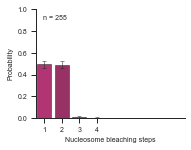

In [17]:
fig,axes = plt.subplots()
protein = 'NUC'

sns.barplot(x='bleaching_steps',y='probability',data=_plot_df, lw=0.5, edgecolor='.15', 
            palette=palettes[protein][1:], ax=axes)
axes.errorbar(x=_plot_df.index,y='probability',data=_plot_df, yerr='standard_error',fmt='none',
             ecolor='.15', elinewidth=0.5, capsize=2, capthick=0.5, capstyle='round')

axes.set_xlim(-0.5,8)
axes.set_ylim(0,1)
axes.set_xlabel('Nucleosome bleaching steps')
axes.set_ylabel('Probability')

axes.text(0.05, 0.95, f"n = {len(pd.melt(df.filter(regex=(protein+'_'),axis=1).xs('bleaching_steps',level='properties',axis=1))['value'].dropna())}",
    verticalalignment='top', horizontalalignment='left',
    transform=axes.transAxes)

#fig.tight_layout()
sns.despine()
# save
plt.savefig(dir_out+'S4D_NUC_bleaching_errorbars.svg',transparent=True)